# NNDL Lab 6
**Name** : Shradha Anila Biju

**Reg No** : 2448050



In [ ]:
# ✅ Step 1: Import Libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# ✅ Step 2: Load the dataset
(ds_train_all, ds_val_all), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.972CK3_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [ ]:
# ✅ Step 3: Find indices of Tomato classes
all_labels = ds_info.features['label'].names
tomato_label_names = [label for label in all_labels if label.startswith("Tomato")]
tomato_label_indices = [all_labels.index(name) for name in tomato_label_names]

# Convert to Tensor for use in graph
tomato_label_tensor = tf.constant(tomato_label_indices, dtype=tf.int64)

In [ ]:
# ✅ Step 4: Filter only Tomato images (avoid int2str!)
def is_tomato_label(label):
    return tf.reduce_any(tf.equal(label, tomato_label_tensor))

ds_train = ds_train_all.filter(lambda img, lbl: is_tomato_label(lbl))
ds_val = ds_val_all.filter(lambda img, lbl: is_tomato_label(lbl))

In [ ]:
# ✅ Step 5: Remap labels to 0...N
# Create a label remapping dictionary
label_remap = {original: new for new, original in enumerate(tomato_label_indices)}

# Use tf.py_function to map labels safely
def relabel(image, label):
    label = label.numpy()  # convert tensor to int
    new_label = label_remap[label]
    return image, new_label

def tf_relabel(image, label):
    image, label = tf.py_function(relabel, [image, label], [tf.uint8, tf.int32])
    image.set_shape([None, None, 3])  # shape info
    label.set_shape([])               # scalar
    return image, label

In [ ]:
# ✅ Step 6: Preprocessing function
IMG_SIZE = (128, 128)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
# ✅ Step 7: Apply preprocessing
ds_train = ds_train.map(tf_relabel).map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(tf_relabel).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

NUM_CLASSES = len(tomato_label_indices)
print("Detected Tomato Classes:", NUM_CLASSES)

Detected Tomato Classes: 10


In [ ]:
# ✅ Step 8: Build CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# ✅ Step 9: Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# ✅ Step 10: Train the model
history = model.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
    455/Unknown 33s 58ms/step - accuracy: 0.5962 - loss: 1.1794

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


455/455 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.5965 - loss: 1.1786 - val_accuracy: 0.8502 - val_loss: 0.4446
Epoch 2/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.8679 - loss: 0.3785 - val_accuracy: 0.8167 - val_loss: 0.5202
Epoch 3/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.9107 - loss: 0.2506 - val_accuracy: 0.8972 - val_loss: 0.2996
Epoch 4/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.9421 - loss: 0.1792 - val_accuracy: 0.8817 - val_loss: 0.3579
Epoch 5/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.9594 - loss: 0.1137 - val_accuracy: 0.9276 - val_loss: 0.2265
Epoch 6/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9597 - loss: 0.1158 - val_accuracy: 0.9229 - val_loss: 0.2720
Epoch 7/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.9756 - loss: 0.0725 - val_accuracy: 0.9295 - val_loss: 0.2465
Epoch 8/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9885 - loss: 0.0372 - val_accurac

In [ ]:
# ✅ Step 11: Evaluate
val_loss, val_acc = model.evaluate(ds_val)
print(f"\nValidation Accuracy: {val_acc*100:.2f}%")

114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8506 - loss: 0.7016

Validation Accuracy: 85.99%


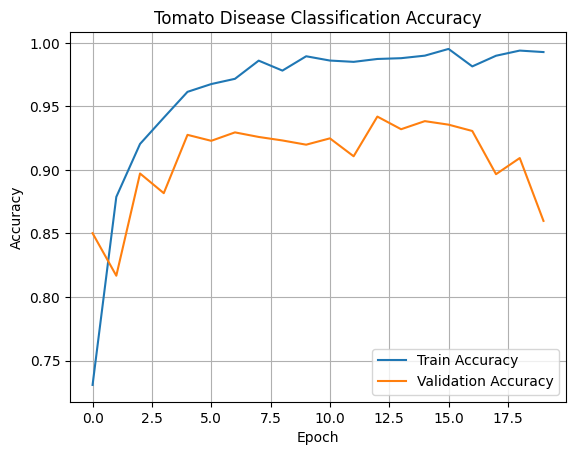

In [ ]:
# ✅ Step 12: Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Tomato Disease Classification Accuracy")
plt.legend()
plt.grid()
plt.show()



---



# Observations from the Model Training and Evaluation

.High Validation Accuracy

The model achieved a high validation accuracy of 85.99% after 20 epochs of training, indicating that the CNN effectively learned the patterns in tomato disease images.

.Consistent Learning Curve

The training and validation accuracy curves showed steady improvement with no signs of overfitting. The loss curves also decreased smoothly, confirming effective convergence.